[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/pgame.ipynb)

# Optimizing with PGAME in Jax

This notebook shows how to use QDax to find diverse and performing controllers in MDPs with [Policy Gradient Assisted MAP-Elites](https://hal.archives-ouvertes.fr/hal-03135723v2/file/PGA_MAP_Elites_GECCO.pdf).
It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create the PGAME emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualize the results of the training process

In [1]:
#@title Installs and Imports
!pip install ipympl |tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

import os

from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

try:
    import brax
except:
    !pip install git+https://github.com/google/brax.git@v0.0.15 |tail -n 1
    import brax

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax


from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids
from qdax import environments
from qdax.tasks.brax_envs import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation, polynomial_mutation
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.age_utils import plot_map_elites_age

from qdax.core.emitters.pga_me_emitter import PGAMEConfig, PGAMEEmitter
from qdax.utils.metrics import CSVLogger, default_qd_metrics

from qdax.core.emitters.inj_me_emitter import InjectionMEEmitter
from qdax.core.containers.age_repertoire import AgeMapElitesRepertoire, Age, age_qd_metrics
from qdax.core.age_mapelites import AgeMAPElites



if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

clear_output()

In [2]:
#@title QD Training Definitions Fields
#@markdown ---
env_name = 'walker2d_uni'#@param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 1000 #@param {type:"integer"}
num_iterations = 4000 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = (128, 128) #@param {type:"raw"}
iso_sigma = 0.005 #@param {type:"number"}
line_sigma = 0.05 #@param {type:"number"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 1024 #@param {type:"integer"}
min_bd = 0. #@param {type:"number"}
max_bd = 1.0 #@param {type:"number"}

#@title PGA-ME Emitter Definitions Fields
proportion_mutation_ga = 0.5

# TD3 params
env_batch_size = 100 #@param {type:"number"}
replay_buffer_size = 100000 #@param {type:"number"}
critic_hidden_layer_size = (256, 256) #@param {type:"raw"}
critic_learning_rate = 3e-4 #@param {type:"number"}
greedy_learning_rate = 3e-4 #@param {type:"number"}
policy_learning_rate = 1e-3 #@param {type:"number"}
noise_clip = 0.5 #@param {type:"number"}
policy_noise = 0.2 #@param {type:"number"}
discount = 0.99 #@param {type:"number"}
reward_scaling = 1.0 #@param {type:"number"}
transitions_batch_size = 256 #@param {type:"number"}
soft_tau_update = 0.005 #@param {type:"number"}
num_critic_training_steps = 100 #@param {type:"number"}
num_pg_training_steps = 100 #@param {type:"number"}
policy_delay = 2 #@param {type:"number"}
#@markdown ---

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [3]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
    activation=jnp.sort,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=env_batch_size)
fake_batch = jnp.zeros(shape=(env_batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=env_batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

## Define the way the policy interacts with the env

In [4]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
  env_state,
  policy_params,
  random_key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)
    
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, random_key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and behavior descriptor of each individual. 

In [5]:
# Prepare the scoring function
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    age_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

## Define the emitter: PG Emitter

The emitter is used to evolve the population at each mutation step. In this example, the emitter is the Policy Gradient emitter, the one used in Policy Gradient Assisted Map Elites. It trains a critic with the transitions experienced in the environment and uses the critic to apply Policy Gradient updates to the policies evolved.

In [6]:
# Define the PG-emitter config
pga_emitter_config = PGAMEConfig(
    env_batch_size=env_batch_size,
    batch_size=transitions_batch_size,
    proportion_mutation_ga=proportion_mutation_ga,
    critic_hidden_layer_size=critic_hidden_layer_size,
    critic_learning_rate=critic_learning_rate,
    greedy_learning_rate=greedy_learning_rate,
    policy_learning_rate=policy_learning_rate,
    noise_clip=noise_clip,
    policy_noise=policy_noise,
    discount=discount,
    reward_scaling=reward_scaling,
    replay_buffer_size=replay_buffer_size,
    soft_tau_update=soft_tau_update,
    num_critic_training_steps=num_critic_training_steps,
    num_pg_training_steps=num_pg_training_steps,
    policy_delay=policy_delay,
)

In [7]:
# Get the emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

# proportion_to_mutate = 0.5
# eta = 0.05
# minval, maxval = -5.12, 5.12

# variation_fn = functools.partial(
#     polynomial_mutation,
#     eta=eta,
#     minval=minval,
#     maxval=maxval,
    # proportion_to_mutate=proportion_to_mutate,
# )
# import importlib
# import qdax.core.emitters.inj_me_emitter as dev_module
# InjectionMEEmitter = importlib.reload(dev_module).InjectionMEEmitter

pg_emitter = InjectionMEEmitter(
    config=pga_emitter_config,
    policy_network=policy_network,
    env=env,
    variation_fn=variation_fn,
)

## Instantiate and initialise the MAP Elites algorithm

In [8]:
# Instantiate MAP Elites
map_elites = AgeMAPElites(
    scoring_function=scoring_fn,
    emitter=pg_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
    random_key=random_key,
)

# compute initial repertoire
repertoire, emitter_state, random_key = map_elites.init(
    init_variables, centroids, random_key
)

/home/paul/Dev/QDax/qdax/core/age_mapelites.py:57: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = AgeMapElitesRepertoire.init(


In [9]:
num_iterations = 100

log_period = 10
num_loops = int(num_iterations / log_period)

csv_logger = CSVLogger(
    "pgame-logs.csv",
    header=[
        "loop", 
        "iteration", 
        "qd_score", 
        "max_fitness", 
        "coverage", 
        "from_actor_ratio", 
        "average_age", 
        "time"
        ]
)
all_metrics = {}

# main loop
map_elites_scan_update = map_elites.scan_update
for i in range(num_loops):
    start_time = time.time()
    # main iterations
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # log metrics
    logged_metrics = {"time": timelapse, "loop": 1+i, "iteration": 1 + i*log_period}
    for key, value in metrics.items():
        # take last value
        logged_metrics[key] = value[-1]

        # take all values
        if key in all_metrics.keys():
            all_metrics[key] = jnp.concatenate([all_metrics[key], value])
        else:
            all_metrics[key] = value

    csv_logger.log(logged_metrics)

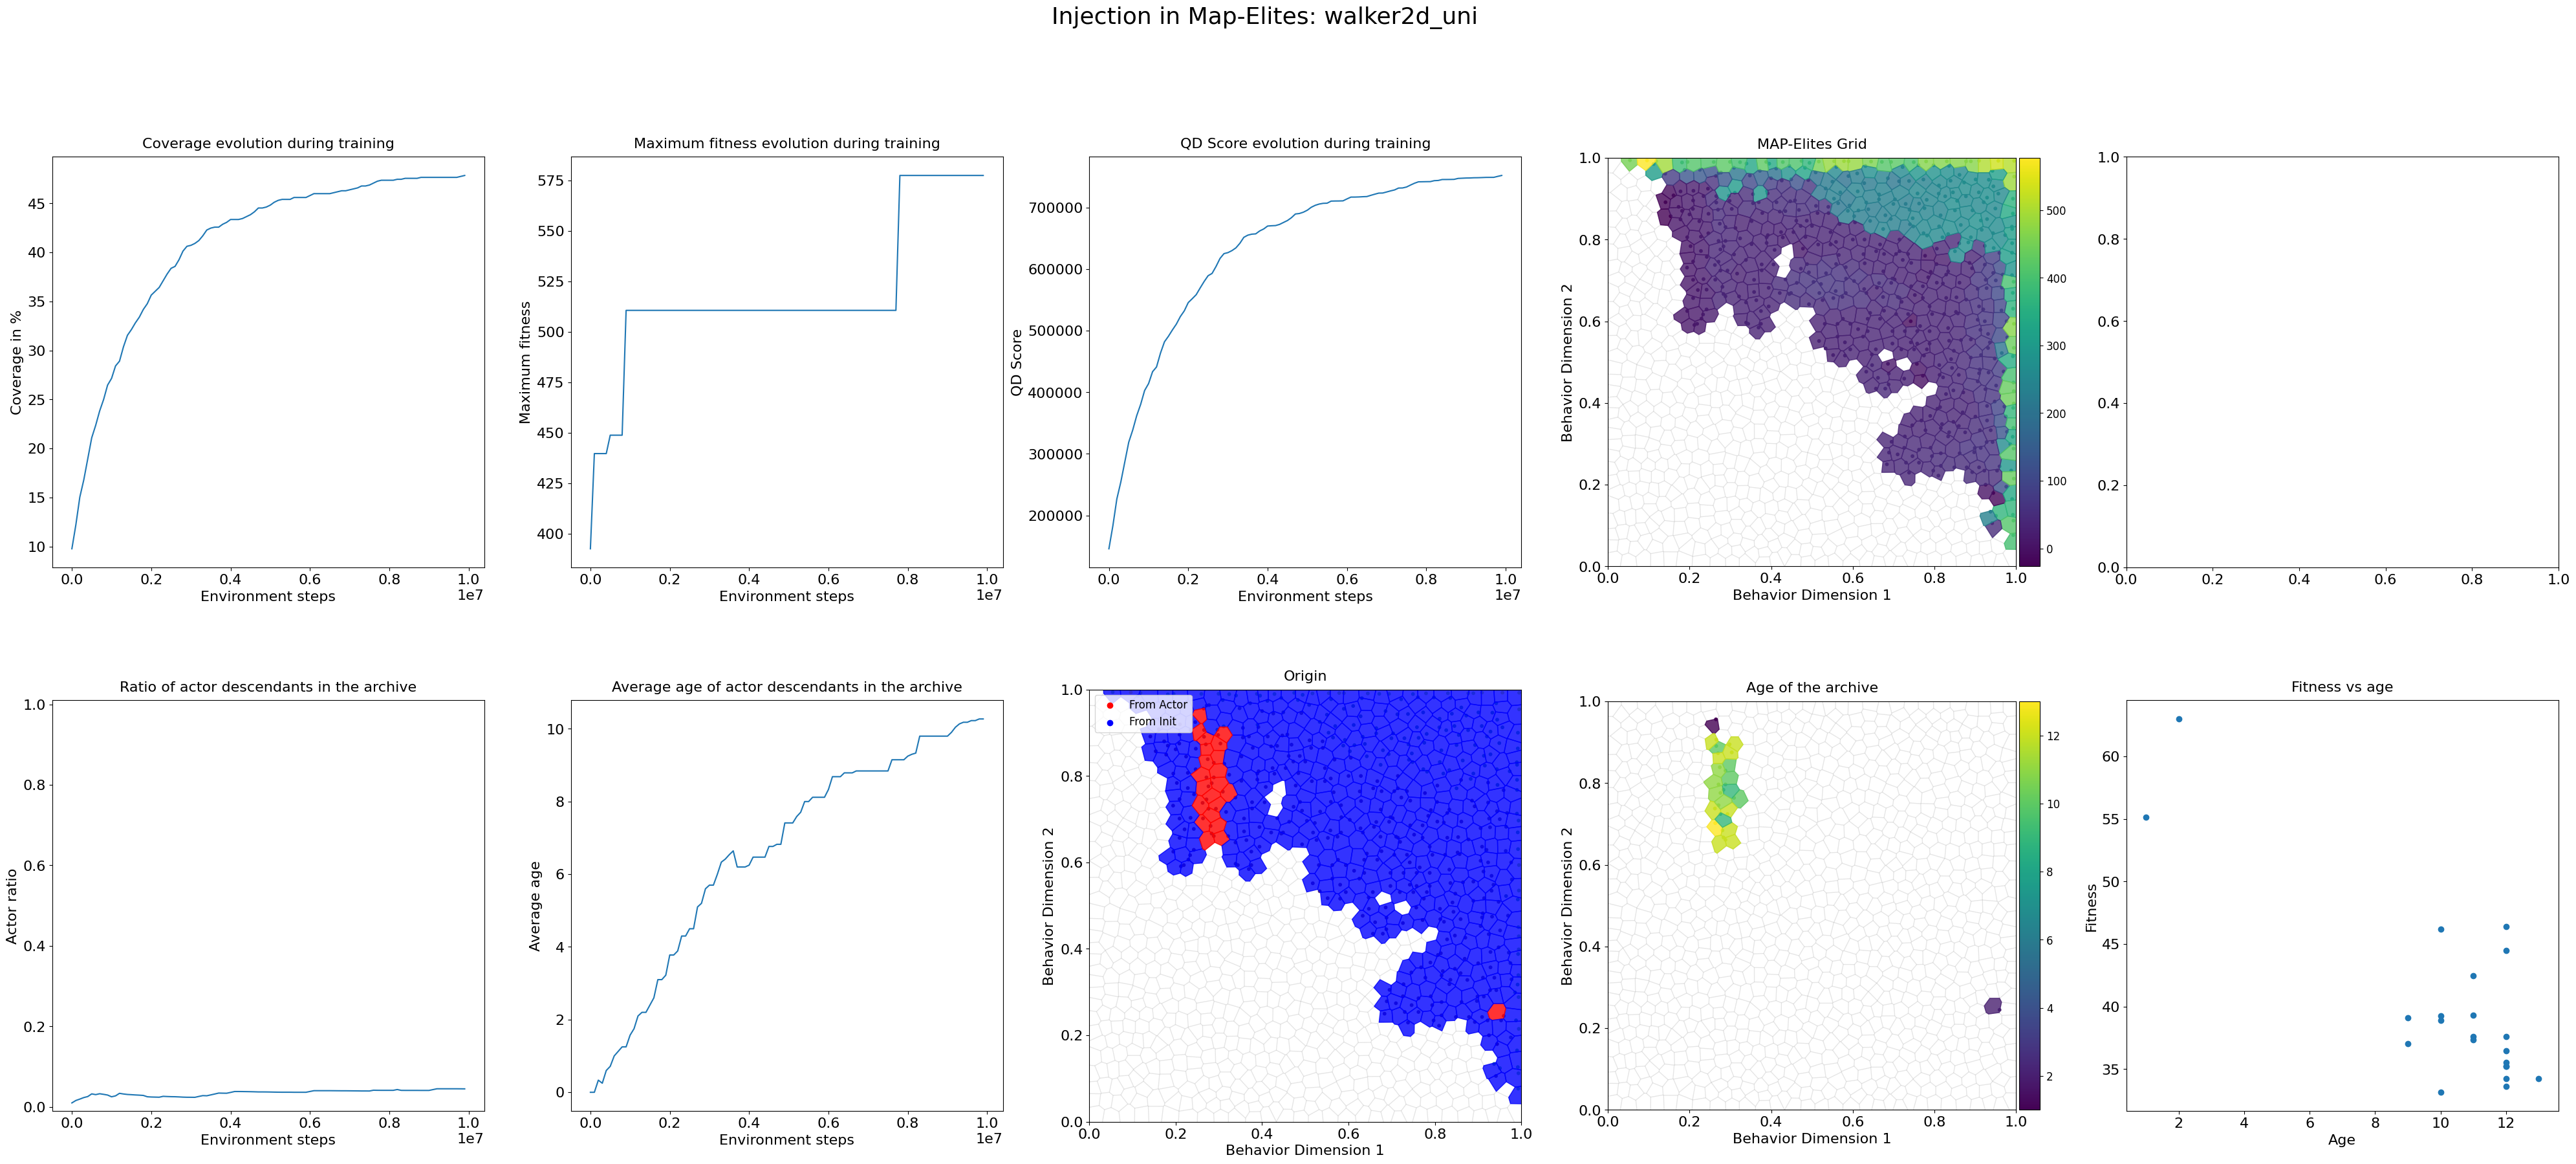

In [10]:
import importlib
import qdax.utils.age_utils as dev_module

plot_map_elites_age = importlib.reload(dev_module).plot_map_elites_age

%matplotlib inline

# create the x-axis array
env_steps = jnp.arange(num_iterations) * episode_length * env_batch_size

title = f"Injection in Map-Elites: {env_name}"
fig, axes = plot_map_elites_age(env_steps=env_steps, metrics=all_metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd, title=title)
fig.savefig(f"plots/injection_{env_name}.png", dpi=300, bbox_inches="tight")

In [11]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_bd = repertoire.descriptors[best_idx]

In [12]:
genes = jax.tree_util.tree_map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

In [13]:
from jax.flatten_util import ravel_pytree
def flatten_genotype(genotype) -> jnp.ndarray:
    flatten_genotype, _ = ravel_pytree(genotype)
    return flatten_genotype

# flatten all the genotypes
flat_genotypes = jax.vmap(flatten_genotype)(repertoire.genotypes)
flat_genotypes.shape

(1024, 19590)

In [14]:
import qdax.core.containers.trajectory_archive as pca_module

PCA = importlib.reload(pca_module).PCA

In [15]:
pca = PCA.init(
    genomes = flat_genotypes,
    # n_dim=10
)

PCA variance: 1.0000001192092896
Computed variance:: 0.9997519850730896


In [16]:
n_dim = 10
var = pca.get_explained_variance(flat_genotypes, n_dim=n_dim)
print(var)
genes_2d = pca.transform(flat_genotypes, n_dim=n_dim)

0.93432224


In [17]:
# get actor genome
actor_params = emitter_state.emitter_states[0].actor_params
flat_actor = flatten_genotype(actor_params)
flat_actor.shape
actor_2d = pca.transform(flat_actor, n_dim=n_dim)

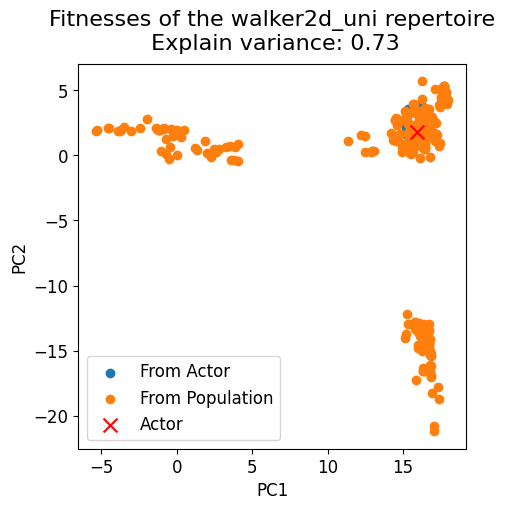

In [18]:
# Scatter
import matplotlib.pyplot as plt
# Add origin as color

origin = repertoire.ages >= 0

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(genes_2d[origin][:, 0], genes_2d[origin][:, 1], label="From Actor")
ax.scatter(genes_2d[~origin][:, 0], genes_2d[~origin][:, 1], label="From Population")
ax.scatter(actor_2d[0], actor_2d[1], c="red", marker="x", s=100, label="Actor")
ax.set_title(f"Fitnesses of the {env_name} repertoire\n Explain variance: {pca.get_explained_variance(flat_genotypes, n_dim=2):.2f}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

/tmp/ipykernel_4054019/2726357111.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(genes_2d[:, 0], genes_2d[:, 1], c=cluster_colors, cmap="viridis")


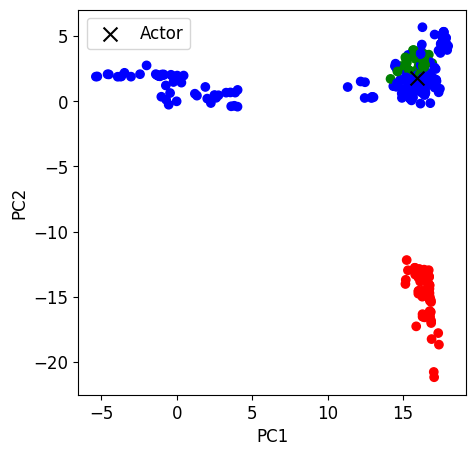

In [19]:
# Cluster
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(genes_2d)
clusters = kmeans.labels_

colors = ["blue", "red", "green"]
cluster_colors = [colors[c] for c in clusters]

# plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(genes_2d[:, 0], genes_2d[:, 1], c=cluster_colors, cmap="viridis")
ax.scatter(actor_2d[0], actor_2d[1], c="k", marker="x", s=100, label="Actor")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

/tmp/ipykernel_4054019/2750374971.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


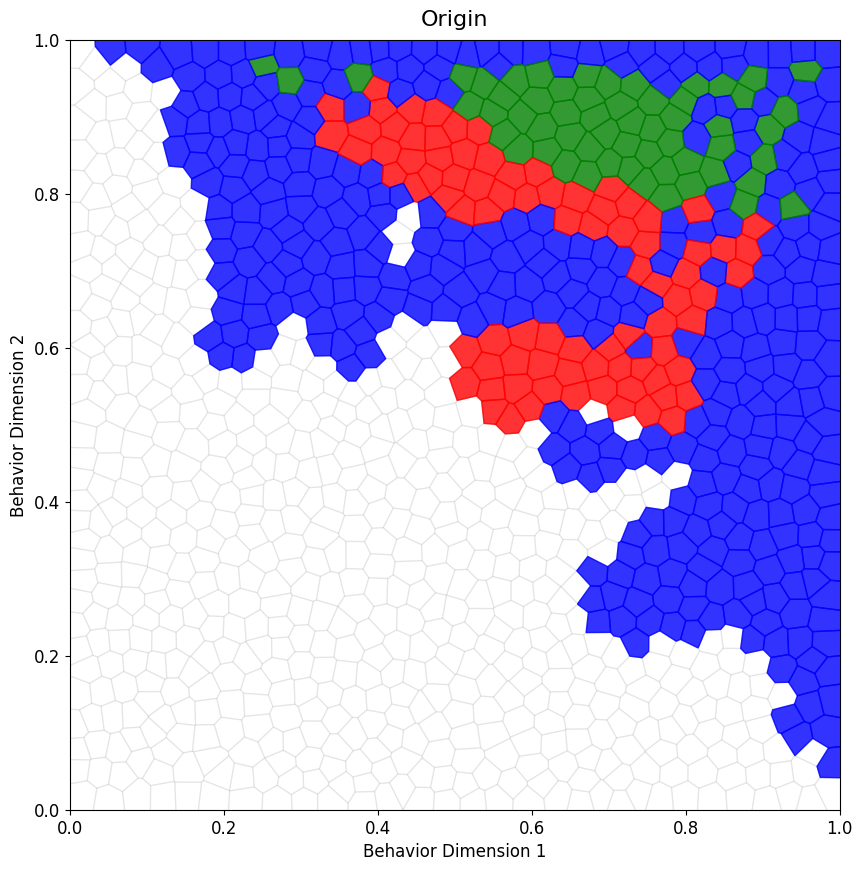

In [20]:
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from qdax.utils.plotting import get_voronoi_finite_polygons_2d, plot_2d_map_elites_repertoire
from matplotlib.colors import Normalize

repertoire_fitnesses = repertoire.fitnesses
repertoire_descriptors = repertoire.descriptors
repertoire_ages = repertoire.ages
centroids = repertoire.centroids
minval = min_bd
maxval = max_bd

grid_empty = repertoire_fitnesses == -jnp.inf
num_descriptors = centroids.shape[1]
if num_descriptors != 2:
    raise NotImplementedError("Grid plot supports 2 descriptors only for now.")

my_cmap = cm.viridis

fitnesses = repertoire_fitnesses
ages = repertoire_ages
vmin = float(jnp.min(fitnesses[~grid_empty]))
vmax = float(jnp.max(fitnesses[~grid_empty]))

# set the parameters
font_size = 12
params = {
    "axes.labelsize": font_size,
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "text.usetex": False,
    "figure.figsize": [10, 10],
}

mpl.rcParams.update(params)

# create the plot object
fig, ax = plt.subplots(facecolor="white", edgecolor="white")
if ax is None:
    fig, ax = plt.subplots(facecolor="white", edgecolor="white")

assert (
    len(np.array(minval).shape) < 2
), f"minval : {minval} should be float or couple of floats"
assert (
    len(np.array(maxval).shape) < 2
), f"maxval : {maxval} should be float or couple of floats"

if len(np.array(minval).shape) == 0 and len(np.array(maxval).shape) == 0:
    ax.set_xlim(minval, maxval)
    ax.set_ylim(minval, maxval)
else:
    ax.set_xlim(minval[0], maxval[0])
    ax.set_ylim(minval[1], maxval[1])

ax.set(adjustable="box", aspect="equal")

# create the regions and vertices from centroids
regions, vertices = get_voronoi_finite_polygons_2d(centroids)

norm = Normalize(vmin=vmin, vmax=vmax)

# fill the plot with contours
for region in regions:
    polygon = vertices[region]
    ax.fill(*zip(*polygon), alpha=0.05, edgecolor="black", facecolor="white", lw=1)

# from_actor_color = "red"
# from_init_color = "blue"
# # Add legend
# ax.scatter([], [], c=from_actor_color, label="From Actor")
# ax.scatter([], [], c=from_init_color, label="From Init")
# ax.legend(loc="upper left")

colors = ["blue", "red", "green"]

# fill the plot with the colors
for idx, fitness in enumerate(fitnesses):
    if fitness > -jnp.inf:
        color = colors[clusters[idx]]
        # print(color)
        # if age >= 0:
        #     # color = from_actor_color
        # else:
            # color = from_init_color
        
        region = regions[idx]
        polygon = vertices[region]

        ax.fill(*zip(*polygon), alpha=0.8, color=color)


# aesthetic
ax.set_xlabel("Behavior Dimension 1")
ax.set_ylabel("Behavior Dimension 2")

ax.set_title("Origin")
ax.set_aspect("equal")
# force to show the plot without inline

fig.show()

In [21]:
# change matplotlib backend to show
%matplotlib inline

In [22]:
# compute initial repertoire
base_repertoire, base_emitter_state, random_key = map_elites.init(
    init_variables, centroids, random_key
)

In [23]:
base_flat = jax.vmap(flatten_genotype)(base_repertoire.genotypes)
idx = base_repertoire.fitnesses > -jnp.inf
print(sum(idx))

base_flat = jax.tree_util.tree_map(
    lambda x: x[idx],
    base_flat
)

origin = jnp.zeros(sum(idx), dtype=bool)

# base_flat = jax.vmap(flatten_genotype)(init_variables)
# origin = jnp.zeros(base_flat.shape[0], dtype=bool)

base_flat.shape

62


(62, 19590)

In [24]:
PCA = importlib.reload(pca_module).PCA
base_pca = PCA.init(
    genomes = base_flat,
    center_last = False,
    # n_dim=10
)
n_dim = 10
var = pca.get_explained_variance(base_flat, n_dim=n_dim)
print(var)

base_2d = pca.transform(base_flat, n_dim=n_dim)
base_2d.shape

PCA variance: 1.0
Computed variance:: 1.0
0.5597398


(62, 10)

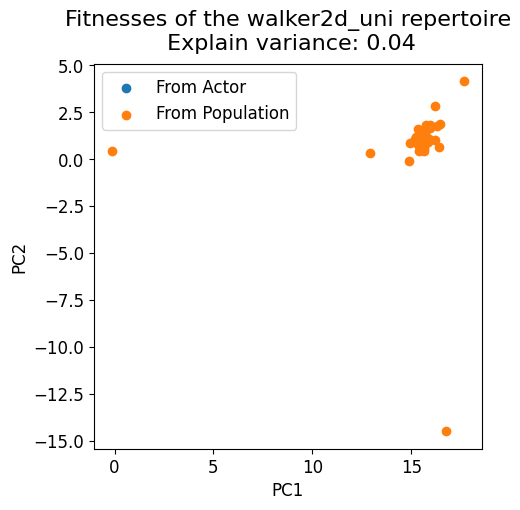

In [25]:
# Scatter
import matplotlib.pyplot as plt
# Add origin as color

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(base_2d[origin][:, 0], base_2d[origin][:, 1], label="From Actor")
ax.scatter(base_2d[~origin][:, 0], base_2d[~origin][:, 1], label="From Population")
ax.set_title(f"Fitnesses of the {env_name} repertoire\n Explain variance: {base_pca.get_explained_variance(base_flat, n_dim=2):.2f}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

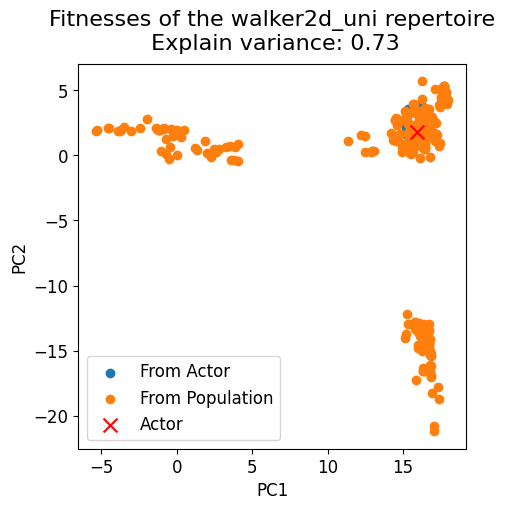

In [26]:
origin = repertoire.ages >= 0

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(genes_2d[origin][:, 0], genes_2d[origin][:, 1], label="From Actor")
ax.scatter(genes_2d[~origin][:, 0], genes_2d[~origin][:, 1], label="From Population")
ax.scatter(actor_2d[0], actor_2d[1], c="red", marker="x", s=100, label="Actor")
ax.set_title(f"Fitnesses of the {env_name} repertoire\n Explain variance: {pca.get_explained_variance(flat_genotypes, n_dim=2):.2f}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

Final genotype shape: (490, 19590)
Base genotype shape: (62, 19590)
Init genotype shape: (100, 19590)
PCA variance: 0.9999998211860657
Computed variance:: 0.9998079538345337
0.7563059
Final 2D variance ratio: 0.27
Final 10D variance ratio: 0.83
Base 2D variance ratio: 0.04
Base 10D variance ratio: 0.18
Init 2D variance ratio: 0.02
Init 10D variance ratio: 0.12


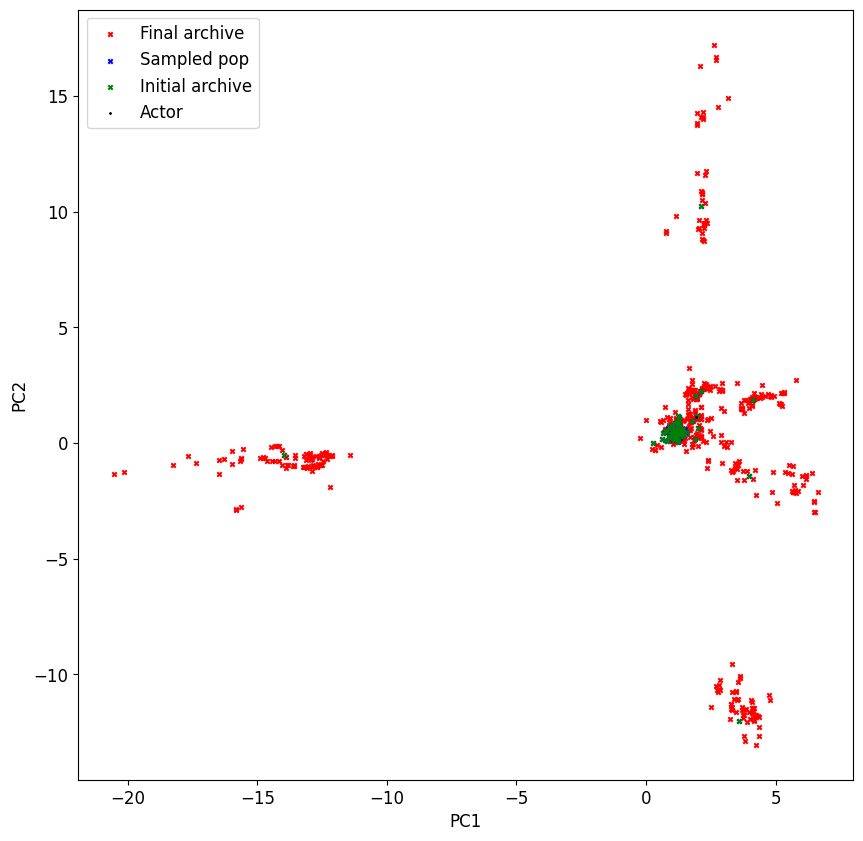

In [27]:
flat_genotypes = jax.vmap(flatten_genotype)(repertoire.genotypes)
idx = repertoire.fitnesses > -jnp.inf
flat_genotypes = flat_genotypes[idx]
print(f"Final genotype shape: {flat_genotypes.shape}")

base_flat = jax.vmap(flatten_genotype)(base_repertoire.genotypes)
idx = base_repertoire.fitnesses > -jnp.inf
base_flat = base_flat[idx]
print(f"Base genotype shape: {base_flat.shape}")

init_flat = jax.vmap(flatten_genotype)(init_variables)
print(f"Init genotype shape: {init_flat.shape}")

all_genotypes = jnp.concatenate([flat_genotypes, base_flat], axis=0)

pca = PCA.init(
    genomes = all_genotypes,
    center_last = False,
    # n_dim=10
)
n_dim = 10
var = pca.get_explained_variance(all_genotypes, n_dim=n_dim)
print(var)

genes_2d = pca.transform(flat_genotypes, n_dim=n_dim)
print(f"Final 2D variance ratio: {pca.get_explained_variance(flat_genotypes, n_dim=2):.2f}")
print(f"Final 10D variance ratio: {pca.get_explained_variance(flat_genotypes, n_dim=10):.2f}")

base_2d = pca.transform(base_flat, n_dim=n_dim)
print(f"Base 2D variance ratio: {pca.get_explained_variance(base_flat, n_dim=2):.2f}")
print(f"Base 10D variance ratio: {pca.get_explained_variance(base_flat, n_dim=10):.2f}")

init_2d = pca.transform(init_flat, n_dim=n_dim)
print(f"Init 2D variance ratio: {pca.get_explained_variance(init_flat, n_dim=2):.2f}")
print(f"Init 10D variance ratio: {pca.get_explained_variance(init_flat, n_dim=10):.2f}")

# get actor genome
actor_params = emitter_state.emitter_states[0].actor_params
flat_actor = flatten_genotype(actor_params)
flat_actor.shape
actor_2d = pca.transform(flat_actor, n_dim=n_dim)

# Scatter
import matplotlib.pyplot as plt
# Add origin as color

s = 10
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(genes_2d[:, 0], genes_2d[:, 1], marker="x", label="Final archive", s=s, color='r')
ax.scatter(init_2d[:, 0], init_2d[:, 1], marker="x", label="Sampled pop", s=s, color='b')
ax.scatter(base_2d[:, 0], base_2d[:, 1], marker="x", label="Initial archive", s=s, color='g')
ax.scatter(actor_2d[0], actor_2d[1], c="k", marker="o", s=1, label="Actor")
# ax.set_title(f"Fitnesses of the {env_name} repertoire\n Explain variance: {base_pca.get_explained_variance(base_flat, n_dim=2):.2f}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()

- make pca clusters and show on BD map
- do 1 actor in each cluster
- landscape analysis between cluster centers

In [28]:
import qdax.core.neuroevolution.networks.groupsort as dev_groupsort

GroupSort = importlib.reload(dev_groupsort).GroupSort

ModuleNotFoundError: No module named 'qdax.core.neuroevolution.networks.groupsort'

In [ ]:
gs = GroupSort(1)

In [ ]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x = jax.random.uniform(subkey, shape=(10, ))

# gs(x)

In [ ]:
k = 1

groups = [x[i:i+k] for i in range(0, x.shape[-1], k)]
groups = jnp.array(groups)
print(groups)
sorted_groups = jax.vmap(jnp.sort)(groups)
sorted_groups

[[0.34896135]
 [0.48210478]
 [0.02053976]
 [0.53161216]
 [0.6306212 ]
 [0.78698325]
 [0.07476437]
 [0.04522789]
 [0.3543167 ]
 [0.06176627]]


DeviceArray([[0.34896135],
             [0.48210478],
             [0.02053976],
             [0.53161216],
             [0.6306212 ],
             [0.78698325],
             [0.07476437],
             [0.04522789],
             [0.3543167 ],
             [0.06176627]], dtype=float32)

In [ ]:
k = 5
n = 11
x = jax.random.uniform(key, shape=(n, ))
x

DeviceArray([0.8502544 , 0.7877791 , 0.45033503, 0.5314127 , 0.5107037 ,
             0.01480567, 0.24824023, 0.88977826, 0.36215663, 0.09948564,
             0.55391765], dtype=float32)

In [ ]:
# split x into k groups
group_size = n // k + int(n % k > 0)
groups = [x[i:i+group_size] for i in range(0, n, group_size)]
groups

[DeviceArray([0.8502544 , 0.7877791 , 0.45033503], dtype=float32),
 DeviceArray([0.5314127 , 0.5107037 , 0.01480567], dtype=float32),
 DeviceArray([0.24824023, 0.88977826, 0.36215663], dtype=float32),
 DeviceArray([0.09948564, 0.55391765], dtype=float32)]